# Welcome to CSE 276F, Assignment 1

Welcome to CSE 276F - Embodied AI. The goal of the course and assignments is to introduce a plethora aspects of embodied AI and how we work towards autonomous physical AI. The course covers topics from Sense Plan Act to Reinforcement Learning based approaches to robotics.

In assignment 1 we will first introduce the structure of the assignment and provide foundations for all future assignments for working and learning with robots. You will learn how to use the [Gymnasium/Gym](https://gymnasium.farama.org/) interface for working with interactive environments, and learn how to build your own simulated robotics environments via [ManiSkill](https://github.com/haosulab/ManiSkill) which is based on [SAPIEN](https://github.com/haosulab/SAPIEN), a GPU parallelized robotics simulator and renderer.

Using these tools we will explore the basics of robotics, and build a script to pick up cubes in simulation with a robot arm.

## Setup Code / Packages

If you are running code locally follow the installation instructions for ManiSkill here: https://maniskill.readthedocs.io/en/latest/user_guide/getting_started/installation.html. You will need a CUDA-enabled GPU on a Linux machine for assignments. Windows/Mac have more limited support but are useful if that is the local machine you have access to for local debugging. When building custom environments you can then use a GUI to explore environments which helps the development process.

If you are using UCSD Datahub you don't need to do any additional installation steps. You only need to run `pip install --upgrade mani_skill-nightly`

If you are using Google Colab make sure to run the two cells below to install all dependencies.

If you see an error such as

`ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject`

simply restart the notebook after running the installation commands.

In [ ]:
# setup vulkan
!mkdir -p /usr/share/vulkan/icd.d
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/nvidia_icd.json
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/10_nvidia.json
!mv nvidia_icd.json /usr/share/vulkan/icd.d
!mv 10_nvidia.json /usr/share/glvnd/egl_vendor.d/10_nvidia.json
!apt-get install -y --no-install-recommends libvulkan-dev
# dependencies
!pip install --upgrade mani_skill-nightly

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libvulkan1
Recommended packages:
  mesa-vulkan-drivers | vulkan-icd
The following NEW packages will be installed:
  libvulkan-dev libvulkan1
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,020 kB of archives.
After this operation, 17.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvulkan1 amd64 1.3.204.1-2 [128 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvulkan-dev amd64 1.3.204.1-2 [892 kB]
Fetched 1,020 kB in 1s (704 kB/s)
Selecting previously unselected package libvulkan1:amd64.
(Reading database ... 126332 files and directories currently installed.)
Preparing to unpack .../libvulkan1_1.3.204.1-2_amd64.deb ...
Unpacking libvulkan1:amd64 (1.3.204.1-2) ...
Selecting previously unselected package libvulkan-dev:amd64.
Preparing to unpa

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import site
    site.main() # run this so local pip installs are recognized

## 1 Using Gymnasium and ManiSkill

No problems are assigned here but understanding the code APIs/interfaces and functionalities are important for this and future assignments.

### 1.1 Gymnasium Basics
The foundation of the gymnasium package is a standardized API for interactive environments. Gym environments can be created by a string environment ID and receive any additional kwargs (keyword arguments) via `gym.make`.

The created environment object will then have pre-defined action and observation spaces and support a few key functions detailed in the code below. Observation space define the format of observations returned by the environment upon resetting or taking a step. Action spaces define the format of actions accepted by the environment

In [70]:
import mani_skill
import gymnasium as gym
# create environment. Specific to ManiSkill you can specify how many parallel environments you want to run
# and what format the observations should be in.
env = gym.make("PegInsertionSide-v1", num_envs=1, obs_mode="state", render_mode="rgb_array")

print("Observation Space", env.observation_space)
print("Action Space", env.action_space)

Observation Space Box(-inf, inf, (1, 43), float32)
Action Space Box(-1.0, 1.0, (8,), float32)


<img src="https://gymnasium.farama.org/_images/AE_loop.png" width="50%"/>

The overall interaction loop is shown above (photo from gymnasium docs). After resetting the environment we repeatedly step through the environment with actions, which return us observation data, reward data, and three more values (described later).

In [71]:
# reset the environment, usually this means sampling new initial states of objects/robots
obs, _ = env.reset()
print("Reset observation shape", obs.shape)

# step the environment, take some action to control the agent in the environment. Neatly we can sample
# actions from the action space
action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(action)
print("Step observation shape", obs.shape)
print(info)

Reset observation shape torch.Size([1, 43])
Step observation shape torch.Size([1, 43])
{'elapsed_steps': tensor([1], dtype=torch.int32), 'success': tensor([False]), 'peg_head_pos_at_hole': tensor([[-0.2708,  0.1408, -0.0753]])}


Each `env.step` call returns observation and reward. The observation describes what the agent *sees*, and should use that information to decide on its next action. The reward value is specific for reinforcement learning based methods and is a scalar signal indicating how well the agent is performing in the environment. We won't be using this until we study reinforcement learning in a future assignment.

`terminated` indicates whether the environment completed/should not run longer, possibly because the agent entered some irrecoverable failure state or has already solved the task. If this is true then usually the environment should be reset.

`truncated` indicates whether the environment has run out of time and should be reset (to prevent endless loops).

`info` contains auxiliary information. In ManiSkill there is often a `info["success"]` value which indicates whether the environment is in a success state.

For those familiar with gym interfaces, ManiSkill has one slight difference from typical gym environments: It is GPU parallelized, and for the purpose of consistency, all data returned by ManiSkill is batched by default.

To understand what is happening in an environment you can use the `env.render` function which does something depending on the `render_mode` argument passed to `gym.make`. Since `render_mode="rgb_array"`, `env.render` returns a RGB array you can visualize as so

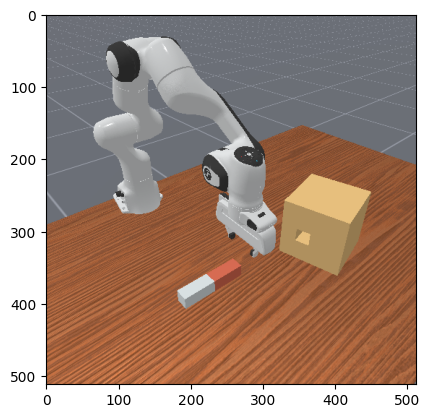

In [72]:
import matplotlib.pyplot as plt
image = env.render() # note maniskill rendering is batched and will return data on the GPU when possible for speed
image = image.cpu().numpy()[0]
plt.imshow(image)

With these core functionalities we can build the basic interaction loop that consists of a reset followed by steps until terminated or truncated is True. We can also record a video as well

In [4]:
obs, _ = env.reset()
done = False
images = [env.render().cpu().numpy()[0]]
# keep taking steps until either we terminated or truncate
while not done:
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    images.append(env.render().cpu().numpy()[0])
    done = terminated or truncated

# save a video
from mani_skill.utils.visualization import images_to_video
images_to_video(images, output_dir="videos", video_name="example", fps=20)

Video created: videos/example.mp4


100%|██████████| 101/101 [00:00<00:00, 752.87it/s]


In [117]:
from IPython.display import Video
Video("./videos/example.mp4", embed=True, width=640) # Watch our replay

### 1.2 ManiSkill Specific Functionalities

Gymnasium describes a core API for interactive environments. ManiSkill builds on that to provide tools for all kinds of robotics-specific work, such as creating custom robotics environments, fast GPU parallelized simulation+rendering, high-quality rendering, and more. There are also a ton of pre-built environments documented on the [tasks page](https://maniskill.readthedocs.io/en/latest/tasks/index.html)

We show a few examples below. For more in-depth details you can look at the [ManiSkill Documentation](https://maniskill.readthedocs.io/en/latest/user_guide/). Some of these features will be used in future assignments

#### GPU Parallelized Simulation + Rendering

(note you may need to restart the notebook to run the next cell as currently a single python process can only run one of CPU or GPU simulation)

/home/zhw/.conda/envs/robolearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Obs shape torch.Size([16, 31])
Render shape torch.Size([16, 512, 512, 3])


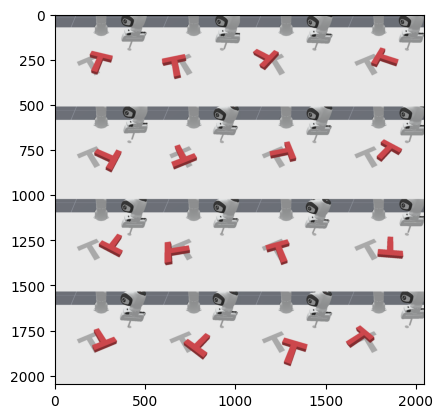

In [1]:
import mani_skill.envs
import gymnasium as gym
import matplotlib.pyplot as plt
from mani_skill.utils.visualization import tile_images
env = gym.make("PushT-v1", num_envs=16)
obs, _ = env.reset()
print("Obs shape", obs.shape) # note it has batch size of 16 now
img = env.unwrapped.render_rgb_array() # if render mode is not set you can still call this to render images for inspection
print("Render shape", img.shape)
img = tile_images(img, nrows=4).cpu().numpy() # tile the images into one image to view
plt.imshow(img)

#### High Quality Rendering / Ray Tracing
(note this only works on linux machines, and colab does not support this)

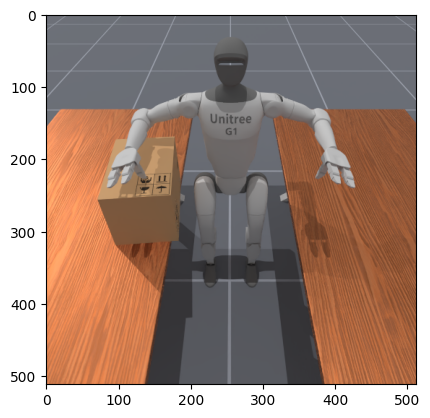

In [4]:
import mani_skill.envs
import gymnasium as gym
import matplotlib.pyplot as plt
# Only supported on CUDA-enabled GPUs on linux at the moment
shader = "rt" # you can also use "rt-fast" for faster ray-traced renders
env = gym.make("UnitreeG1TransportBox-v1", num_envs=1, human_render_camera_configs=dict(shader_pack=shader))
env.reset()
img = env.unwrapped.render_rgb_array()
plt.imshow(img.cpu().numpy()[0])

#### Visual Observation Modes

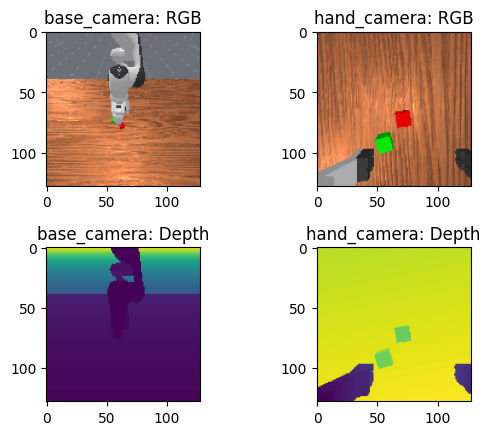

In [73]:
import mani_skill.envs
import gymnasium as gym
import matplotlib.pyplot as plt
env = gym.make("StackCube-v1", num_envs=1, obs_mode="rgb+depth")
obs, _ = env.reset()
rgbs = []
depths = []
fig, ax = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.4)
for i, camera_name in enumerate(obs["sensor_data"].keys()):
    cam_data = obs["sensor_data"][camera_name]
    rgbs.append(cam_data["rgb"].cpu().numpy()[0])
    depths.append(cam_data["depth"])
    ax[0, i].title.set_text(f'{camera_name}: RGB')
    ax[1, i].title.set_text(f'{camera_name}: Depth')
    ax[0, i].imshow(cam_data["rgb"].cpu().numpy()[0])
    ax[1, i].imshow(cam_data["depth"].cpu().numpy()[0])

## 2 Poses (4 pts)

The first problem is understanding how poses work in robotics. We will use the ManiSkill package to play around with pose data. Play with the code below to get a sense of how to create Pose objects, and some recommended tools for creating them particularly around working with rotations. Note that

- In robotics, we typically use quaternions to represent rotations.
- Pose data is always in the world frame
- All data is kept as batched torch tensors in ManiSkill

In [74]:
import mani_skill.envs
from mani_skill.utils.structs.pose import Pose
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
# create a pose object. The default values are always the identity pose and data always has a batch dimension
pose = Pose.create_from_pq(p=[0, 0, 0], q=[1, 0, 0, 0])
print(f"pos={pose.p}, quat={pose.q}")

pos=tensor([[0, 0, 0]]), quat=tensor([[1, 0, 0, 0]])


In [75]:
# pose transformations via multiplication operators
pose1 = Pose.create_from_pq(p=[-0.5, 0, 0], q=[1, 0, 0, 0])
pose2 = Pose.create_from_pq(p=[1, 0, 0])
pose = pose1 * pose2
print(f"pos={pose.p}, quat={pose.q}")

pos=tensor([[0.5000, 0.0000, 0.0000]]), quat=tensor([[1., 0., 0., 0.]])


In [76]:
from transforms3d.euler import euler2quat
# euler2quat converts euler angles to quaternions. A convenient way to
# go from interpretable rotations (e.g. 90 degrees around z-axis) to quaternions
pose = Pose.create_from_pq(p=[-0.5, 0, 0], q=euler2quat(0, 0, np.pi/2))
print(f"pos={pose.p}, quat={pose.q}")

pos=tensor([[-0.5000,  0.0000,  0.0000]]), quat=tensor([[0.7071, 0.0000, 0.0000, 0.7071]])


In [11]:
# multiplying a pose by its inverse will cancel out the transformation. There may be some floating point imprecisions however
pose1 = Pose.create_from_pq(p=[-0.5, 0, 0], q=euler2quat(0, 0, np.pi/2))
pose = pose1 * pose1.inv()
print(f"pos={pose.p}, quat={pose.q}")

pos=tensor([[-5.9605e-08,  0.0000e+00,  0.0000e+00]]), quat=tensor([[1.0000, 0.0000, 0.0000, 0.0000]])


You can also access the objects in simulation and retrieve data like their poses as done below. We can see that the peg
is at position `[-0.0007, -0.0695,  0.0222]` and has rotation `[0.8344, 0.0000, 0.0000, 0.5511]`

We also see the pose of the robot's root link. Note that conventionally in robotics the robot reference frame is oriented around the robot's root link.

Finally you can also access the "end-effector" reference frame which is already defined for you and is the point between the two grippers on the robot

peg pos=tensor([[-0.0007, -0.0695,  0.0222]]), quat=tensor([[0.8344, 0.0000, 0.0000, 0.5511]])
root link pos=tensor([[-6.1500e-01,  7.2760e-11, -1.4901e-08]]), quat=tensor([[1.0000, 0.0000, 0.0000, 0.0000]])
ee link pos=tensor([[0.0074, 0.0238, 0.1753]]), quat=tensor([[0.0027, 0.6976, 0.7164, 0.0122]])


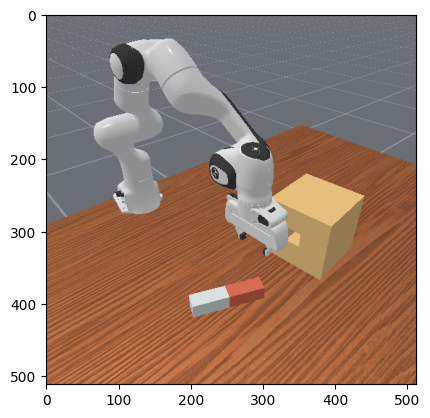

In [7]:
env = gym.make("PegInsertionSide-v1", num_envs=1)
env.reset(seed=0)
peg_actor = env.unwrapped.peg
robot_base_link = env.unwrapped.agent.robot.root
end_effector_link = env.unwrapped.agent.robot.links_map["panda_hand_tcp"]
pose = peg_actor.pose
print(f"peg pos={pose.p}, quat={pose.q}")
pose = robot_base_link.pose
print(f"root link pos={pose.p}, quat={pose.q}")
pose = end_effector_link.pose
print(f"ee link pos={pose.p}, quat={pose.q}")
plt.imshow(env.unwrapped.render_rgb_array()[0].cpu().numpy())

### Problem 2.1 (1pt):

Set the peg's object such that it is rotated by 90 degrees clockwise. Use `peg_actor.set_pose` api to set to the `Pose` object you create.

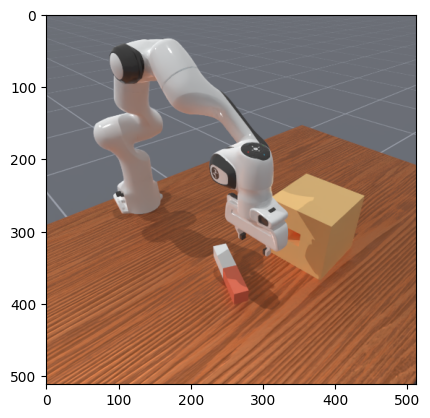

In [8]:
env = gym.make("PegInsertionSide-v1", num_envs=1, human_render_camera_configs=dict(shader_pack="rt"))
env.reset(seed=0)
peg_actor = env.unwrapped.peg
# peg_actor.set_pose(Pose.create_from_pq(p=[0, 0, 0.2], q=[1, 0, 0, 0])) # example usage

### your code goes below ###
import torch
# rotate 90 degrees around z axis
quat = torch.tensor(euler2quat(0, 0, -np.pi/2))
T_rotate = Pose.create_from_pq(p=torch.zeros(3), q=quat)
T_peg = peg_actor.pose
# apply transformation
T_res = T_rotate * T_peg
peg_actor.set_pose(T_res)
### your code goes above ###

### eval code ###
plt.imshow(env.unwrapped.render_rgb_array()[0].cpu().numpy())
plt.savefig("p_2.1.png")

### Problem 2.2 (1pt):

What is the pose of the peg in the robot base's reference frame? Compute it below

In [77]:
env = gym.make("PegInsertionSide-v1", num_envs=1)
env.reset(seed=0)
peg_actor = env.unwrapped.peg
robot_base_link = env.unwrapped.agent.robot.root

### your code goes below ###
robot_base_pose = robot_base_link.pose
peg_pose = peg_actor.pose
pose = robot_base_pose.inv() * peg_pose
### your code goes above ###

### eval code ###
P2_2_ANSWER = pose
print(f"peg in robot base frame pos={pose.p}, quat={pose.q}")

peg in robot base frame pos=tensor([[ 0.6143, -0.0695,  0.0222]]), quat=tensor([[0.8344, 0.0000, 0.0000, 0.5511]])


### Problem 2.3 (1pt):

Set the peg pose such that it is upright, white part on top, orange part on the bottom, and does not intersect the table (it's okay if its floating).

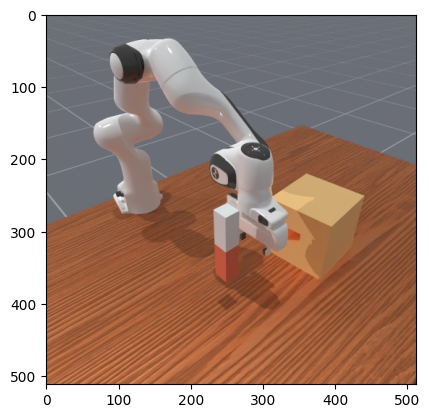

In [10]:
env = gym.make("PegInsertionSide-v1", num_envs=1, human_render_camera_configs=dict(shader_pack="rt"))
env.reset(seed=0)
peg_actor = env.unwrapped.peg

### your code goes below ###
import torch

# desired orienation
quat_desired = euler2quat(0, np.pi/2, 0)
# desired translation
current_p = peg_actor.pose.p
diff_p = torch.tensor([0, 0, 0.2])
desired_p = current_p + diff_p

T_res = Pose.create_from_pq(p=desired_p, q=quat_desired)
peg_actor.set_pose(T_res)
### your code goes above ###

### eval code ###
plt.imshow(env.unwrapped.render_rgb_array()[0].cpu().numpy())
plt.savefig("p_2.3.png")

### Problem 2.4 (1pt):

What is the pose of the peg in the end-effector's reference frame? Compute it below

In [78]:
env = gym.make("PegInsertionSide-v1", num_envs=1)
env.reset(seed=0)
peg_actor = env.unwrapped.peg
end_effector_link = env.unwrapped.agent.robot.links_map["panda_hand_tcp"]

### your code goes below ###
eef_pose = end_effector_link.pose
peg_pose = peg_actor.pose
pose = eef_pose.inv() * peg_pose
### your code goes above ###

### eval code ###
P2_4_ANSWER = pose
print(f"peg in end-effector frame pos={pose.p}, quat={pose.q}")

peg in end-effector frame pos=tensor([[-0.0951, -0.0138,  0.1517]]), quat=tensor([[ 0.0090, -0.9769, -0.2133, -0.0087]])


## 3 Joints and Controllers (6 pts)

We will now look to understand how robot joints work and learn how we control them in sim/real. We will explore three class of controllers often used in simulation. `PDJointPosController`, `PDJointPosMimicController` and `PDEEPoseController`

In our simulation, each robot has several possible control modes which may use multiple controllers to control various joints. The `pd_joint_pos` uses two of these types below:

In [12]:
import mani_skill.envs
import gymnasium as gym
import matplotlib.pyplot as plt
# from mani_skill.utils.visualization import tile_images
env = gym.make("PickCube-v1", num_envs=1, control_mode="pd_joint_pos")
# you can print the controller object of the agent to see what each joint is controlled by
print(env.unwrapped.agent.controller)

CombinedController(dof=8, active_joints=9
    arm: PDJointPosController(dof=7, active_joints=7, joints=(panda_joint1, panda_joint2, panda_joint3, panda_joint4, panda_joint5, panda_joint6, panda_joint7))
    gripper: PDJointPosMimicController(dof=1, active_joints=2, mimic_to_control_joint_map={
        panda_finger_joint2: panda_finger_joint1,
    })
)


`PDJointPosController` is straightforward and lets you directly control each joint with its own action/signal. Each degree of freedom (7 DOf) corresponds with one of the active joints (7 of them).

`PDJointPosMimicController` is like the PDJointPosController but instead some joints are implicitly controlled depending on the signal sent to the other joints that they mimic. In this case the joint called `panda_finger_joint2` mimics how `panda_finger_joint1` is controlled. Hence the DOF is 1 but 2 joints are actively moving.

We will look at one more control mode below, `pd_ee_pose`

In [13]:
env = gym.make("PickCube-v1", num_envs=1, control_mode="pd_ee_pose")
print(env.unwrapped.agent.controller)

CombinedController(dof=7, active_joints=9
    arm: PDEEPoseController(dof=6, active_joints=7, end_link=panda_hand_tcp, joints=(panda_joint1, panda_joint2, panda_joint3, panda_joint4, panda_joint5, panda_joint6, panda_joint7))
    gripper: PDJointPosMimicController(dof=1, active_joints=2, mimic_to_control_joint_map={
        panda_finger_joint2: panda_finger_joint1,
    })
)


This controller uses `PDEEPoseController`, which has a DOF 6 with 7 active joints. This is done via inverse kinematics (IK), which computes the necessary joint positions that achieve a particular pose/position of some robot link at the end of those joints.

### Problem 3.1 (2 pt):

Recall that there are several kinds of joints typically used in real world robots. Revolute and prismatic joints are the most common and also have simulated counterparts.

The robot in the following environment has 9 joints in total. Your objective here is to record a video of each joint moving by itself, there should be a total of 8 videos since 1 joint is implicitly controlled by mimicking another. After which then label each joint in the next table with whether they are revolute or prismatic.

The example code provided will generate 8 videos of the robot moving to random places. Edit it to control one joint at a time (joint 0, 1, 2, ..., 7), and then fill the following table.

In [ ]:
import mani_skill.envs
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from mani_skill.utils.wrappers.record import RecordEpisode

env = gym.make("PickCube-v1", robot_uids="panda", render_mode="rgb_array", control_mode="pd_joint_pos", human_render_camera_configs=dict(shader_pack="default"))
# RecordEpisode(env, ...) adds a functionality such that each call to env.reset() will save a new video to videos/
env = RecordEpisode(env, output_dir="videos_3.1/", save_trajectory=False, video_fps=20)
# qpos is an abbreviation of joint positions
# note that for the pd_joint_pos controller the finger joints are controlled by a mimic controller and is normalized from -1 to 1.
default_qpos = np.array([0.0, np.pi / 8, 0, -np.pi * 5 / 8, 0, np.pi * 3 / 4, np.pi / 4, 1])

for joint_i in range(8):
    env.reset(seed=0)
    robot = env.unwrapped.agent.robot
    robot.set_qpos(np.array([0.0, np.pi / 8, 0, -np.pi * 5 / 8, 0, np.pi * 3 / 4, np.pi / 4, 0.04, 0.04]))

    ### your code goes below ###
    # modify this code to control just one joint at a time and make it visibly move
    # Control joint 0 first, then 1, 2, ...

    target_qpos = default_qpos.copy()
    # joints each 30 degree
    if joint_i < 7:
        target_qpos[joint_i] += np.pi/6
    # gripper 
    else:
        target_qpos[7] = 0.0

    for _ in range(10):
        env.step(target_qpos)

    ### your code goes above ###
env.reset()

### eval code ###
# code below will make a grid of videos showing each video in sequence labelled
# by the joint name (video 0 -> first joint, video 1 -> second joint)
from IPython.display import HTML
from base64 import b64encode

html_str="<div style='display:flex; flex-wrap: wrap'>"
filepaths = [f"./videos_3.1/{x}.mp4" for x in range(8)]
for i, filepath in enumerate(filepaths):
  mp4 = open(filepath,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  html_str += f"""
  <div style='width=100px'>
    <p>{env.agent.robot.active_joints[i].name}</p>
    <video width=256 controls autoplay loop>
        <source src="{data_url}" type="video/mp4">
    </video>
  </div>
  """
html_str+= "</div>"
HTML(html_str)

In [80]:
### your code goes below ###
# joint type must be one of "revolute" or "prismatic", follow the spelling and capitalization exactly!

panda_joint_1_joint_type = "revolute"
panda_joint_2_joint_type = "revolute"
panda_joint_3_joint_type = "revolute"
panda_joint_4_joint_type = "revolute"
panda_joint_5_joint_type = "revolute"
panda_joint_6_joint_type = "revolute"
panda_joint_7_joint_type = "revolute"
panda_finger_joint1_joint_type = "prismatic"

### your code goes above ###

### Problem 3.2 (4 pts):

The previous problem uses the direct joint position control to move a robot arm to desired joint positions. But this is a little impractical for humans to control with because the joint space is not interpretable. Hence sometimes in robotics we tend to use inverse kinematics (IK) for end-effector based control. The `pd_ee_pose` controller demonstrated below accepts actions in the form of a 3D position (in the robot base frame) concatenated with a 3D rotation (represented as euler angles centered at the end-effector), which are human interpretable and easy to work with.

For a fun task we will use this more interpretable controller to draw some shapes. The objective for this problem is to modify the code below to control the end-effector such that it contacts the canvas, and follows the black triangles outline to draw a red triangle (when the robot contacts the canvas, red ink is drawn on). There is only one triangle configuration you are tested on.

Some requirements:
- Write a script such that the robot draws connected lines. If the robot moves too fast the drawing is disconnected, how can you slow it down?
- The drawing of the red triangle should mostly cover the black triangle (you will need to hardcode some positions/values to make it work via trial and error)
- lift the robot arm off the canvas at the end so we can see the drawing!
- Complete it in less than 300 calls to `env.step` (code will raise a error if you go over)

If you are ever confused about how end effector control works or how it behaves with respect to translation and rotation in different reference frames, [this is a good resource with videos showing how different reference frames change end effector control behavior](https://maniskill.readthedocs.io/en/latest/user_guide/concepts/controllers.html#pd-ee-end-effector-pose)

In [ ]:
import mani_skill.envs
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from mani_skill.utils.wrappers.record import RecordEpisode
from transforms3d.euler import quat2euler
env = gym.make("DrawTriangle-v1", render_mode="rgb_array", control_mode="pd_ee_pose", human_render_camera_configs=dict(shader_pack="default"))
print("Controller:", env.unwrapped.agent.controller)
env = RecordEpisode(env, output_dir="videos_3.2_example/", save_trajectory=False) # RecordEpisode(env, ...) adds a functionality such that each call to env.reset() will save a new video to videos/
env.reset(seed=0)

robot_pose = env.unwrapped.agent.robot.pose
end_effector_link = env.unwrapped.agent.robot.links_map["panda_hand_tcp"]

# we need the end effector pose in the robot base frame as the controller works in that frame
ee_pose_in_robot_base_frame = robot_pose.inv() * end_effector_link.pose

ee_pos = ee_pose_in_robot_base_frame.p[0].numpy()
ee_euler_angles = np.array(quat2euler(ee_pose_in_robot_base_frame.q[0].numpy()))

# stay still at where we compute the end effector to be at with open gripper, robot might shift a little due to some imprecision
for _ in range(5):
    action = np.concatenate([ee_pos, ee_euler_angles])
    env.step(action)


### your code goes below. Existing code is just an example, you will need to modify it ###

# move the end effector down by 10cm to contact the drawing board, rotate about the z-axis, then move to the right by 5cm
# these actions are very easy to define now with end effector IK based control
'''ee_pos[2] -= 0.1
ee_euler_angles[2] += np.pi/4
for _ in range(10):
    action = np.concatenate([ee_pos, ee_euler_angles])
    env.step(action)
ee_pos[1] += 0.05
for _ in range(10):
    action = np.concatenate([ee_pos, ee_euler_angles])
    env.step(action)
'''

# EEpose in base frame
from transforms3d.quaternions import quat2mat
# init pose
init_ee_pos = ee_pos.copy()
init_ee_euler = ee_euler_angles.copy()
# desired z
ee_z_pos = init_ee_pos[2] - 0.1
# base p
robot_base_p = robot_pose.p[0].numpy()
robot_base_quat = robot_pose.q[0].numpy()


# triangle reference trajectory in world frame
vertices_in_world = env.unwrapped.vertices[0].numpy()
trajectory_in_world = env.unwrapped.triangles[0].numpy()
point_z_world = 0.02
z_column = np.full((trajectory_in_world.shape[0], 1), point_z_world)
trajectory_in_world = np.concatenate([trajectory_in_world, z_column], axis=1)
steps_per_point = 10
max_total_steps = 300
max_points = max_total_steps // steps_per_point - 1

n = trajectory_in_world.shape[0]
if n > max_points:
    indices = np.linspace(0, n-1, max_points).astype(int)
    trajectory_in_world = trajectory_in_world[indices]

trajectory_len = trajectory_in_world.shape[0]

# robot pose
def get_pos(env, robot_pose=robot_pose):
    """
    Get current robot eef pose in base frame
    """
    end_effector_link = env.unwrapped.agent.robot.links_map["panda_hand_tcp"]
    ee_pose_in_robot_base_frame = robot_pose.inv() * end_effector_link.pose

    ee_pos = ee_pose_in_robot_base_frame.p[0].numpy()
    ee_euler_angles = np.array(quat2euler(ee_pose_in_robot_base_frame.q[0].numpy()))
    '''for _ in range(5):
        action = np.concatenate([ee_pos, ee_euler_angles])
        env.step(action)'''

    return ee_pos, ee_euler_angles

for i in range(trajectory_len):
    # get reference point in world frame
    point_world = trajectory_in_world[i]
    # transform to base frame
    rot_world_in_base = quat2mat(robot_base_quat).T
    point_base = rot_world_in_base @ (point_world - robot_base_p)

    # get current eef pose and orientation
    cur_ee_pos, cur_ee_euler = get_pos(env)
    direction = point_base[:2] - cur_ee_pos[:2]
    desired_yaw = np.arctan2(direction[1], direction[0])
    
    # desired ee pose in base frame
    desired_ee_pos = np.array([point_base[0], point_base[1], ee_z_pos])
    desired_ee_euler = np.array([cur_ee_euler[0], cur_ee_euler[1], desired_yaw])

    for _ in range(10):
        action = np.concatenate([desired_ee_pos, desired_ee_euler])
        env.step(action)


### your code goes above ###


success = env.unwrapped.get_info()["success"].item()

### eval code ###
env.reset() # save video
print("Triangle drawn correctly", success)
from IPython.display import Video
Video("./videos_3.2_example/0.mp4", embed=True, width=640)

Controller: CombinedController(dof=6, active_joints=7
    arm: PDEEPoseController(dof=6, active_joints=7, end_link=panda_hand_tcp, joints=(panda_joint1, panda_joint2, panda_joint3, panda_joint4, panda_joint5, panda_joint6, panda_joint7))
)
tensor([[-6.1500e-01,  7.2760e-11, -1.4901e-08]])
Triangle drawn correctly True


## 4 Building Simulated Robotics Tasks and Solving Them (8 pts)

Simulation presents an opportunity to work and research with robots without having to buy them!

This part of the assignment will take you through the steps on how to make a custom robotics task with the Panda arm we have modelled for you, culminating in you using motion planning to solve the task. It will include parts on

- how to load the robot arm into simulation
- use prepackaged scenes (like a table)
- load objects (e.g. a cube, ball, cup)
- set up some 3rd-view sensors
- using motion planning to generate robot motions

### Problem 4.1 (4 pts):

Your first goal is to create a custom simulated task that uses the Panda robot to pick up a blue cube and drop it inside a wooden bin on a table.

We provide some starter code below to initialize a tabletop setup and default to loading the Panda robot arm. For now don't write a solution to this task, simply fill in the code to add objects, initialize them, and a success condition check if the cube is in the wooden bin.

Ultimately it should look something like this:

![](https://github.com/StoneT2000/paper-assets/raw/refs/heads/main/projects/cse276f/p5_what_it_looks_like.png)

The box shape should just be a blue color, and the wooden bin should have a wooden texture (we provide an image you can use). If you need help/references you can follow the tutorial we provide here for more details on creating custom simulated tasks: https://maniskill.readthedocs.io/en/latest/user_guide/tutorials/custom_tasks/index.html (read at least the introduction to task building page)

Visually compare your environment with the one in the photo above, as run as the evaluation code to ensure things are mostly working correctly.

In [7]:
# download diffuse texture file
!wget https://github.com/StoneT2000/paper-assets/raw/refs/heads/main/projects/cse276f/rosewood_veneer1_diff_1k.png

--2025-04-28 20:19:08--  https://github.com/StoneT2000/paper-assets/raw/refs/heads/main/projects/cse276f/rosewood_veneer1_diff_1k.png
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/StoneT2000/paper-assets/refs/heads/main/projects/cse276f/rosewood_veneer1_diff_1k.png [following]
--2025-04-28 20:19:08--  https://media.githubusercontent.com/media/StoneT2000/paper-assets/refs/heads/main/projects/cse276f/rosewood_veneer1_diff_1k.png
Resolving media.githubusercontent.com (media.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5535381 (5.3M) [image/png]
Saving to: ‘rosewood_veneer1_diff_1k.png.1’

rosewood_veneer1_

In [85]:
import sapien
import numpy as np
import gymnasium as gym
from mani_skill.utils import sapien_utils, common
from mani_skill.envs.sapien_env import BaseEnv
from mani_skill.utils.registration import register_env
from mani_skill.utils.scene_builder.table import TableSceneBuilder
from mani_skill.sensors.camera import CameraConfig
from mani_skill.utils import common, sapien_utils
from mani_skill.utils.structs.pose import Pose
from mani_skill.utils.wrappers.record import RecordEpisode
import torch
from transforms3d.euler import euler2quat

@register_env("DropCubeInBinPanda-v1", max_episode_steps=50, override=True)
class DropCubeInBinPandaEnv(BaseEnv):
    bin_wall_halfsize = [0.08, 0.008, 0.05]
    bin_bottom_halfsize = [0.08, 0.08, 0.008]
    cube_halfsize = [0.02, 0.02, 0.02]

    def __init__(self, *args, robot_uids="panda", **kwargs):
        # pass robot_uids to super().__init__, this lets maniskill auto load a robot for you
        super().__init__(*args, robot_uids=robot_uids, **kwargs)

    @property
    def _default_human_render_camera_configs(self):
        ### your code goes below, tune the eye and target so that you can see the robot, bin, table, and box. ###
        pose = sapien_utils.look_at(eye=[0.7, 0.5, 0.4], target=[-0.5, 0.0, 0.1])
        ### your code goes above ###

        return CameraConfig(
            "render_camera", pose=pose, width=512, height=512, fov=1, near=0.01, far=100
        )

    def _load_agent(self, options: dict):
        super()._load_agent(options, sapien.Pose(p=[0, 0, 1]))

    def _load_lighting(self, options: dict):
        self.scene.set_ambient_light([0.3, 0.3, 0.3])
        self.scene.add_directional_light(
            [1, 1, -1], [1, 1, 1], shadow=True, shadow_scale=5, shadow_map_size=2048
        )
        self.scene.add_directional_light([0, 0, -1], [1, 1, 1])

    def _load_scene(self, options: dict):
        # we use a prebuilt scene builder class that automatically loads in a floor and table.
        self.table_scene = TableSceneBuilder(
            env=self
        )
        # this build command will automatically build a table and ground plane such that the table top is at z=0.
        self.table_scene.build()
        wood_material = sapien.render.RenderMaterial()
        wood_material.base_color_texture = sapien.render.RenderTexture2D("rosewood_veneer1_diff_1k.png")

        ### your code goes below ###
        # make sure to save the bin actor as self.bin and cube actor as self.cube
        # the bin should use the wood_material for all sides and bottom, and cube should just be red

        # cube
        cube_builder = self.scene.create_actor_builder()
        cube_builder.add_box_collision(
            half_size=self.cube_halfsize
        )
        cube_builder.add_box_visual(
            half_size=self.cube_halfsize,
            material=sapien.render.RenderMaterial(
                base_color=[1, 0, 0, 1],
            ),
        )
        cube_builder.initial_pose = sapien.Pose(p=[0, 0, 0.02], q=[1, 0, 0, 0])
        self.cube = cube_builder.build(name="cube")

        # bin
        bin_builder = self.scene.create_actor_builder()
        # bottom
        bin_builder.add_box_collision(
            half_size=self.bin_bottom_halfsize,
            pose = sapien.Pose(p=[0,0, -self.bin_bottom_halfsize[2]], q=[1, 0, 0, 0]),
        )
        bin_builder.add_box_visual(
            half_size=self.bin_bottom_halfsize,
            pose = sapien.Pose(p=[0,0, -self.bin_bottom_halfsize[2]], q=[1, 0, 0, 0]),
            material=wood_material
        )
        # walls
        wall_pose_offsets = [
            [0, self.bin_bottom_halfsize[1] - self.bin_wall_halfsize[1], self.bin_wall_halfsize[2]],   # front
            [0, -self.bin_bottom_halfsize[1] + self.bin_wall_halfsize[1], self.bin_wall_halfsize[2]],  # back
            [self.bin_bottom_halfsize[0] - self.bin_wall_halfsize[1], 0, self.bin_wall_halfsize[2]],   # right
            [-self.bin_bottom_halfsize[0] + self.bin_wall_halfsize[1], 0, self.bin_wall_halfsize[2]],  # left
        ]
        for i, offset in enumerate(wall_pose_offsets):
            if i >= 2:  
                quat = sapien.Pose(q=[np.cos(np.pi/4), 0, 0, np.sin(np.pi/4)]).q  
            else:  
                quat = [1, 0, 0, 0]  
            bin_builder.add_box_collision(
                half_size=self.bin_wall_halfsize,
                pose=sapien.Pose(p=offset, q=quat)
            )
            bin_builder.add_box_visual(
                half_size=self.bin_wall_halfsize,
                pose=sapien.Pose(p=offset, q=quat),
                material=wood_material
            )
        bin_builder.initial_pose = sapien.Pose(p=[0.2, 0, 0.1], q=[1, 0, 0, 0])
        self.bin = bin_builder.build(name="bin")


        # replace these with a reference to the created actors
        #self.bin = None
        ### your code goes above ###

    def _initialize_episode(self, env_idx: torch.Tensor, options: dict):
        # using torch.device context manager to auto create tensors
        # on CPU/CUDA depending on self.device, the device the env runs on
        with torch.device(self.device):
            # the number of parallel envs running, it is just 1 in this assignment but recall that all data in maniskill is batched by default
            b = len(env_idx)

            # this initialization will automatically place the table and ground plane in the right place
            # and put the panda arm at the edge of the table
            self.table_scene.initialize(env_idx)

            ### your code goes below ###
            # write code to randomly sample some bin position and box positions, ensure they don't overlap/collide
            # but are close enough to the robot that the task is solvable. Ensure as well they don't start intersecting the table
            q = [1, 0 ,0 ,0]
            # get robot base pose
            robot_base_pose = self.agent.robot.pose
            robot_base_xy = robot_base_pose.p[0, :2]
            print(robot_base_xy.shape)
            print(robot_base_xy)

            # set random range
            bin_rand_range = [-0.2, 0.2]
            cube_rand_range = [-0.15, 0.15]
            min_dist = 0.3

            # sample xy
            #bin_xy = torch.rand((b, 2)) * (rand_range[1] - rand_range[0]) + rand_range[0]  
            #cube_xy = torch.rand((b, 2)) * (rand_range[1] - rand_range[0]) + rand_range[0]
            bin_xy = torch.zeros((b,2))
            cube_xy = torch.zeros((b,2))

            for i in range(b):
                valid = False
                while not valid:
                    bin_xy[i] = (torch.rand((2,)) * (bin_rand_range [1] - bin_rand_range [0]) + bin_rand_range[0])
                    cube_xy[i] = (torch.rand((2,)) * (cube_rand_range[1] - cube_rand_range[0]) + cube_rand_range[0])
                    if torch.norm(bin_xy[i] - cube_xy[i]) > min_dist:
                        valid = True
            # set z
            table_top_z = 0.01
            bin_z = table_top_z + self.bin_bottom_halfsize[2]
            cube_z = table_top_z + self.cube_halfsize[2]

            # set bin
            bin_p = torch.zeros((b,3))
            bin_p[..., :2] = bin_xy
            bin_p[..., 2] = bin_z
            bin_pose = Pose.create_from_pq(p=bin_p, q=q)
            self.bin.set_pose(bin_pose)

            # set cube

            cube_p = torch.zeros((b, 3))
            cube_p[..., :2] = cube_xy
            cube_p[..., 2] = cube_z
            cube_pose = Pose.create_from_pq(p=cube_p, q=q)
            self.cube.set_pose(cube_pose)

            ### your code goes above ###

    def evaluate(self):
        success = torch.zeros((self.num_envs, ), dtype=bool)
        ### your code goes below ###
        '''cube_pose = self.cube.pose.p
        bin_pose = self.bin.pose.p
        diff = torch.linalg.norm(cube_pose[..., :2] - bin_pose[..., :2], axis=1)
        success_threshold = 0.05
        success = diff < success_threshold'''
        cube_pose = self.cube.pose.p   # (b, 3)
        bin_pose = self.bin.pose.p     # (b, 3)
        bin_halfsize = torch.tensor(self.bin_bottom_halfsize, device=cube_pose.device)  # (3,)
        lower_bound = bin_pose[..., :2] - bin_halfsize[:2]
        upper_bound = bin_pose[..., :2] + bin_halfsize[:2]
        inside_xy = (cube_pose[..., 0] >= lower_bound[..., 0]) & (cube_pose[..., 0] <= upper_bound[..., 0]) & \
                    (cube_pose[..., 1] >= lower_bound[..., 1]) & (cube_pose[..., 1] <= upper_bound[..., 1])

        expected_z = bin_pose[..., 2] + self.bin_bottom_halfsize[2] + self.cube_halfsize[2]
        z_close = torch.abs(cube_pose[..., 2] - expected_z) < 0.05
        success = inside_xy & z_close


        ### your code goes above ###
        return dict(success=success)

2025-04-29 00:21:03,417 - mani_skill  - WARNING - Override registered env DropCubeInBinPanda-v1


2025-04-29 00:21:13,544 - mani_skill  - WARNING - mani_skill is not installed with git.


torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
CombinedController(dof=8, active_joints=9
    arm: PDJointPosController(dof=7, active_joints=7, joints=(panda_joint1, panda_joint2, panda_joint3, panda_joint4, panda_joint5, panda_joint6, panda_joint7))
    gripper: PDJointPosMimicController(dof=1, active_joints=2, mimic_to_control_joint_map={
        panda_finger_joint2: panda_finger_joint1,
    })
)


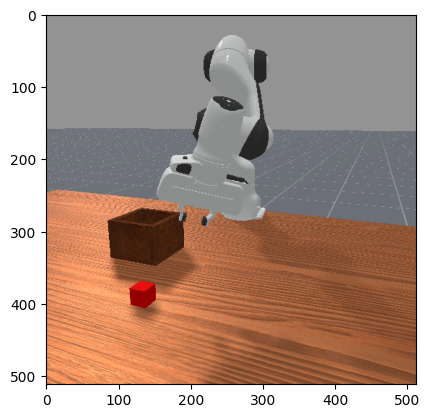

In [86]:
### evaluation code below ###
import matplotlib.pyplot as plt
env = gym.make("DropCubeInBinPanda-v1",
               num_envs=1,
               control_mode="pd_joint_delta_pos",
               render_mode="rgb_array",
               reward_mode="none",
               human_render_camera_configs=dict(shader_pack="default")
)
env = RecordEpisode(env, output_dir="drop_cube", video_fps=20, info_on_video=True)
env.reset(seed=42)
cube = env.unwrapped.cube
bin = env.unwrapped.bin
print(env.unwrapped.agent.controller)
for t in range(50):
    _, _, _, _, info = env.step(env.action_space.sample())
    forces = env.unwrapped.scene.get_pairwise_contact_forces(cube, bin)
    assert np.linalg.norm(forces) < 1e-4, "the cube and bin are intersecting! something is not right with your episode initialiation"
    assert not info["success"], "task was solved somehow. Make sure your success condition is correct and you aren't spawning the box inside the bin already"
img = env.render().cpu().numpy()[0]
env.close()
plt.imshow(img)
### evaluation code above ###

### Problem 4.2 (4 pts):

In part 4.1 we made our own simulated task to test with, now we want to try and solve it properly.

In part 3 we played around with robot joints and different types of controllers, ultimately writing a script to control a robot to draw a triangle while ensuring the robot doesn't move too fast and follows the outline properly. Motion planning libraries help ensure some of those constraints are met by providing some general tooling to plan a sequence of joint position actions given just poses.

We will now try and control the robot in your custom task to grasp the red cube, pick it up, and drop it in the wooden bin (somewhat harder task compared to drawing a triangle).

We will be controlling this robot with the following controller setup:
- All joints except the gripper joints are controlled by a PD joint controller
- The two gripper joints are controlled via a single mimic controller (one action controls both joints at the same time).

The following code sets up a motion planning library for you and saves some useful variables.

In particular you have

- `planner`: The planner object which lets you use screw motion planning or RRT motion planning. (you can follow the example code, screw plan works fine)
- `panda_hand_tcp`: The panda hand tool center point "link", which gives the current pose of the link we are controlling via the motion planning library. This is the point in the middle between the two panda arm grippers
- `cube`: The cube actor object, which you can use to access its current pose.
- `bin`: The bin actor object.

The motion planner setup will generate a sequence joint position actions for all the joints excluding the gripper. The gripper action you can manually pick (can range from -1 to 1). The existing code provided shows an example of moving the robot with the motion planner.

The requirements for this problem are:
- Write a motion planning script to control the robot arm to pick up the cube and drop it in the bin.
- Achieve 100% success rate in the 10 evaluation trials

In [87]:
### setup code, don't change! ###
import mani_skill.envs
import gymnasium as gym
import numpy as np
from mani_skill.utils.visualization import images_to_video
from mani_skill.utils.wrappers.record import RecordEpisode
import mplib
from tqdm.notebook import tqdm
from transforms3d.euler import euler2quat, quat2euler
env = gym.make("DropCubeInBinPanda-v1",
               num_envs=1,
               control_mode="pd_joint_pos",
               render_mode="rgb_array",
               reward_mode="none",
               human_render_camera_configs=dict(shader_pack="default")
)
env = RecordEpisode(env, output_dir="drop_cube", video_fps=20, info_on_video=True, save_trajectory=False)
env.reset(seed=42)
robot = env.unwrapped.agent.robot
link_names = [link.get_name() for link in robot.get_links()]
joint_names = [joint.get_name() for joint in robot.get_active_joints()]
planner = mplib.Planner(
    urdf=env.unwrapped.agent.urdf_path,
    srdf=env.unwrapped.agent.urdf_path.replace(".urdf", ".srdf"),
    user_link_names=link_names,
    user_joint_names=joint_names,
    move_group="panda_hand_tcp",
    # ensures planned motions do not exceed these limits
    joint_vel_limits=np.ones(7) * 0.8,
    joint_acc_limits=np.ones(7) * 0.8,
)
# this sets the planner object up such that you can plan with poses in the world frame, which is the default frame of all pose data
# in our simulator
planner.set_base_pose(np.concatenate([robot.pose.sp.p, robot.pose.sp.q]))

torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])


In [88]:
EPISODES = 10

def pick_cube_mp_solution(env):
    robot = env.unwrapped.agent.robot
    panda_hand_tcp = env.unwrapped.agent.robot.links_map["panda_hand_tcp"]
    cube = env.unwrapped.cube
    bin = env.unwrapped.bin
    ### Your code goes here ###
    grasp_ori = panda_hand_tcp.pose.q[0].numpy().copy()
    z_offset = 0.15
    grasp = 1

    # cube pose in world frame
    cube_p = cube.pose.p[0].numpy().copy()
    bin_p = bin.pose.p[0].numpy().copy()

    planner.update_attached_sphere(
        radius=1.0,
        pose=np.concatenate([panda_hand_tcp.pose.p[0].numpy(), panda_hand_tcp.pose.q[0].numpy()]),
        link_id=panda_hand_tcp.get_index()
    )
    
    # grasp the cube
    grasp_result = planner.plan_screw(
        np.concatenate([cube_p + np.array([0,0,z_offset]), grasp_ori]),
        robot.qpos.cpu().numpy()[0],
        time_step=env.unwrapped.control_timestep,
        use_attach=True,
        wrt_world=True
    )
    for pos in grasp_result["position"]:
        env.step(np.concatenate([pos, [grasp]]))

    grasp_result = planner.plan_screw(
        np.concatenate([cube_p, grasp_ori]),
        robot.qpos.cpu().numpy()[0],
        time_step=env.unwrapped.control_timestep,
        use_attach=True,
        wrt_world=True
    )
    for i, pos in enumerate(grasp_result["position"]):
        if i == len(grasp_result["position"]) - 1:
            grasp = -1
        env.step(np.concatenate([pos, [grasp]]))

    # move to bin
    grasp_result = planner.plan_screw(
        np.concatenate([cube_p + np.array([0,0,z_offset]), grasp_ori]),
        robot.qpos.cpu().numpy()[0],
        time_step=env.unwrapped.control_timestep,
        use_attach=True,
        wrt_world=True
    )
    for pos in grasp_result["position"]:
        env.step(np.concatenate([pos, [grasp]]))

    grasp_result = planner.plan_screw(
        np.concatenate([bin_p + np.array([0,0,z_offset]), grasp_ori]),
        robot.qpos.cpu().numpy()[0],
        time_step=env.unwrapped.control_timestep,
        use_attach=True,
        wrt_world=True
    )
    for i, pos in enumerate(grasp_result["position"]):
        if i == len(grasp_result["position"]) - 1:
            grasp = 1
        env.step(np.concatenate([pos, [grasp]]))
    
    # extra steps to see outcome
    for _ in range(5):
        env.step(np.concatenate([robot.qpos.cpu().numpy()[0][:7], [grasp]]))


    ### your code goes above ###

### evaluation code below ###
successes = 0
for i in tqdm(range(EPISODES)):
    env.reset(seed=i)
    pick_cube_mp_solution(env)
    success = env.get_info()["success"].item()
    successes += success
env.reset()
print(f"Success rate: {successes/EPISODES}")

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
torch.Size([2])
tensor([-6.1500e-01,  7.2760e-11])
Success rate: 1.0


In [89]:
from IPython.display import Video
Video("./drop_cube/0.mp4", embed=True, width=640) # Watch our replay

## 5 Submission

If you are taking the CSE 276F course at UC San Diego, to submit your work please save this .ipynb file locally first. Then run the cells below which zips up some of your answers and generated evaluation images/videos for grading.

In [81]:
work_data = {
    "p2_2": P2_2_ANSWER.raw_pose.cpu().tolist()[0],
    "p2_4": P2_4_ANSWER.raw_pose.cpu().tolist()[0],
    "panda_joint_1_joint_type": panda_joint_1_joint_type,
    "panda_joint_2_joint_type": panda_joint_2_joint_type,
    "panda_joint_3_joint_type": panda_joint_3_joint_type,
    "panda_joint_4_joint_type": panda_joint_4_joint_type,
    "panda_joint_5_joint_type": panda_joint_5_joint_type,
    "panda_joint_6_joint_type": panda_joint_6_joint_type,
    "panda_joint_7_joint_type": panda_joint_7_joint_type,
    "panda_finger_joint1_joint_type": panda_finger_joint1_joint_type,
}
import json
with open("answers.json", 'w') as json_file:
    json.dump(work_data, json_file, indent=2)  # Use indent for pretty printing

In [ ]:
!mkdir -p hw_files/p4.2 2> /dev/null
!mkdir -p hw_files/p3.1 2> /dev/null
!mkdir -p hw_files/p3.2 2> /dev/null
!cp p_2.1.png hw_files/
!cp p_2.3.png hw_files/
!cp answers.json hw_files/
!cp drop_cube/*.mp4 hw_files/p4.2
!cp videos_3.1/*.mp4 hw_files/p3.1
!cp videos_3.2_example/*.mp4 hw_files/p3.2
!tar -czvf hw_files.tar.gz hw_files > /dev/null